In [1]:
import os,sys,string,re
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression

    
def clean_category(x):
    if len(x)==0:
        return ''
    x=re.sub(chr(195),'e',x)
    x=re.sub(chr(169),'',x)
    x=x.translate(trans)
    x=re.sub(' +',' ',x)
    x=x.lower()
    x=' '.join(list(set(map(ps.stem,x.split(' ')))))
    x=re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '',x)
    return x
def clean_brand(x):
    return re.sub('[^0-9a-z]','',x.lower())
def get_cat_lookup(df):
    cat_lookup=df.groupby('category_name')['log_price'].apply(lambda x: {'log_price':x.sum(),'count':x.size}).unstack()
    cat_lookup['category_name']=cat_lookup.index
    cat_lookup['category0']=cat_lookup['category_name'].map(lambda x: str(x).split('/')[0]).map(clean_category)
    cat_lookup['category1']=cat_lookup['category_name'].map(lambda x: str(x).split('/')[1] if str(x).count('/')>=1 else 'na').map(clean_category)
    cat_lookup['category2']=cat_lookup['category_name'].map(lambda x: str(x).split('/')[2] if str(x).count('/')>=2 else 'na').map(clean_category)    
    return cat_lookup
def get_group_lookup(df,cols,label,threshold):
    interaction_num=len(cols)
    df_group=df.groupby(cols)['log_price'].apply(lambda x: {'count':x.size,'sum_log_price':x.sum()}).unstack().reset_index()
    df_group['new_grp']=np.where(df_group['count']>threshold,df_group.index,-999)
    df_index_group=df_group.groupby('new_grp')[['count','sum_log_price']].sum()
    df_index_group['freq']=df_index_group['count']/df_index_group['count'].sum()
    df_index_group['avg_log_price']=df_index_group['sum_log_price']/df_index_group['count']
    df_group['sig%d_%d_freq'%(len(cols),label)]=df_group['new_grp'].map(df_index_group['freq'])
    df_group['sig%d_%d_price'%(len(cols),label)]=df_group['new_grp'].map(df_index_group['avg_log_price'])
    df_group=df_group[df_group['new_grp']>=0]
    output_sigs=[x for x in df_group.columns if 'sig' in x]
    missing_vals=[0,df['log_price'].mean()] if -999 not in df_index_group.index else list(df_index_group.ix[-999,['freq','avg_log_price']])
    missing_vals=pd.Series(missing_vals,index=output_sigs)
    return df_group[cols+output_sigs],missing_vals
def get_group_lookups(df):
    interaction_columns=['category0','category1','category2','brand']
    brand_cat_space=[list(x) for i in range(len(interaction_columns)) for x in combinations(interaction_columns,i+1)]
    group_lookups={}
    for i,x in enumerate(brand_cat_space):
        group_lookups[tuple(x)]=get_group_lookup(df,x,i,50)
    return group_lookups
def clean_cat_brand(df):
    df['category0']=df['category_name'].astype(np.str).map(cat_lookup['category0']).fillna('nan')
    df['category1']=df['category_name'].astype(np.str).map(cat_lookup['category1']).fillna('nan')
    df['category2']=df['category_name'].astype(np.str).map(cat_lookup['category2']).fillna('nan')
    df['brand']=df['brand_name'].fillna('nan').astype(np.str).map(clean_brand)
    return df
def get_cat_brand_vars(df):
    interaction_columns=['category0','category1','category2','brand']
    for i,x in group_lookups.items():
        df=pd.merge(df,x[0],on=list(i),how='outer')
        df.fillna(x[1],inplace=True)
    for i in range(len(interaction_columns)):
        for signal in ['freq','price']:
            signals=[x for x in df.columns if 'sig%d'%(i+1) in x and signal in x]
            df['sig%d_max_%s'%(i+1,signal)]=df[signals].max(axis=1)
            df['sig%d_min_%s'%(i+1,signal)]=df[signals].min(axis=1)
            df['sig%d_avg_%s'%(i+1,signal)]=df[signals].mean(axis=1)
    df['cost_in_description']=df['item_description'].astype(np.str).map(lambda x: 1 if '[rm]' in x else 0)
    return df
def get_free_text_vars(df,var,label):
    df['ft_0_%s'%label]=df[var].astype(np.str).str.len()                                                             # Num characters
    df['ft_1_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[%s]'%string.printable,'',x)).str.len()         # Num non printable chars
    df['ft_2_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^#$%&*:;<=>?@\^_`|~]','',x)).str.len()         # Num Special Characters
    df['ft_3_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^0-9]','',x)).str.len()                        # Num numerals
    df['ft_4_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^a-z]','',x)).str.len()                        # Num lower case
    df['ft_5_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^A-Z]','',x)).str.len()                        # Num upper case
    df['ft_6_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^ ]','',x)).str.len()                          # Num spaces
    df['%s_clean'%label]=df[var].astype(np.str).str.lower().map(lambda x: re.sub('[^ a-z]',' ',x))                   # Clean Text
    return df
def clean_text(df):
    df['free_text']=df['name_clean']+' '+df['desc_clean']
    df['free_text']=df['free_text'].map(lambda x: ' '.join([keywords_lookup[y] for y in x.split(' ') if y in keywords_raw]))
    return df
def stem_word(x):
    try:
        return ps.stem(x)
    except:
        return x
def get_vocabulary(df):
    all_words=pd.concat([df['name'],df['item_description']]).values
    all_words=[re.sub('[^ a-z]',' ',y.lower()) for x in all_words for y in str(x).split()]
    all_words=pd.Series(Counter(all_words))
    all_words=all_words[all_words>100]
    stemmed_words=all_words.reset_index()
    stemmed_words.columns=['word','count']
    stemmed_words['stem']=stemmed_words['word'].map(stem_word)
    stemmed_words.index=stemmed_words['word']
    vocabulary=stemmed_words.groupby('stem')['count'].sum()
    vocabulary=vocabulary[vocabulary>=100].index.tolist()
    keywords_raw=set(stemmed_words['word'])
    keywords_lookup=stemmed_words['stem'].to_dict()
    return vocabulary,keywords_raw,keywords_lookup
def get_tfidf_predictions(datasets,column,num_features,output_column):
    vectorizer = TfidfVectorizer(max_features=num_features) if num_features>0 else TfidfVectorizer()
    vectorizer.fit(datasets[0][column].fillna('nan'))
    ft_features=[vectorizer.transform(data[column].fillna('nan')) for data in datasets]
    model = Ridge(alpha=0.1,solver='sag')
    model.fit(ft_features[0],datasets[0]['log_price'])
    for i,ft_feature in enumerate(ft_features):
        datasets[i][output_column]=model.predict(ft_feature)
    return datasets
def get_tfidf_matrix(datasets,column,num_features):
    vectorizer = TfidfVectorizer(max_features=num_features) if num_features>0 else TfidfVectorizer()
    vectorizer.fit(datasets[0][column].fillna('nan'))
    ft_features=[vectorizer.transform(data[column].fillna('nan')) for data in datasets]
    return ft_features
def get_ridge_predictions(datasets,matrix,output_column):
    model = Ridge(alpha=0.1,solver='sag')
    model.fit(matrix[0],datasets[0]['log_price'])
    for i,ft_feature in enumerate(matrix):
        datasets[i][output_column]=model.predict(ft_feature)
    return datasets    



In [101]:
import seaborn as sns

In [62]:
(ins['price']<5).value_counts()

False    1157560
True       28468
Name: price, dtype: int64

In [9]:
#if __name__=='__main__':
if 1==1:
    to_space= '''&,()+'"/'''
    trans=str.maketrans(to_space, ' '*len(to_space)) #Change to str when submitting
    ps = PorterStemmer()

    os.chdir('/data/arpit.goel/31_PricePrediction/03.Submissions')  #Remove while sumbitting
    pd.set_option('display.float_format', lambda x: '%.1f' % x)

    df_raw_train=pd.read_csv('../input/train.tsv',delimiter='\t')
    df_raw_test=pd.read_csv('../input/test.tsv',delimiter='\t')
    df_raw_train['log_price']=np.log(1+df_raw_train['price'])
    #df_raw_train=df_raw_train[df_raw_train['log_price']>1]
    ins=df_raw_train.sample(frac=0.8,random_state=200) #Change to 95/99 percent when submitting
    oos=df_raw_train.drop(ins.index)
    oot=df_raw_test
    datasets=[ins,oos,oot]

In [11]:
df_raw_train['price'].value_counts().sort_index()

0.0         874
3.0       18703
4.0       16139
5.0       31502
5.5          33
6.0       32260
6.5          16
7.0       52268
7.5          34
8.0       61564
8.5          20
9.0       63643
9.5          17
10.0      99416
10.5         38
11.0      39786
11.5         13
12.0      78986
12.5         34
13.0      36800
13.5          4
14.0      76655
14.5         13
15.0      58082
15.5         12
16.0      66413
16.5          7
17.0      21334
17.5          8
18.0      41243
          ...  
1506.0        1
1509.0        1
1515.0        1
1525.0        2
1528.0        1
1550.0        1
1575.0        1
1600.0        3
1609.0        1
1615.0        1
1625.0        1
1700.0        1
1708.0        1
1709.0        1
1747.0        1
1750.0        1
1759.0        1
1770.0        1
1800.0        3
1806.0        2
1808.0        1
1815.0        2
1850.0        2
1900.0        1
1909.0        1
1999.0        1
2000.0        6
2004.0        1
2006.0        1
2009.0        1
Name: price, dtype: int6

In [9]:
if 1==1:
    cat_lookup=get_cat_lookup(datasets[0])
    datasets=[clean_cat_brand(data) for data in datasets]
    group_lookups=get_group_lookups(datasets[0])
    vocabulary,keywords_raw,keywords_lookup=get_vocabulary(datasets[0])
    datasets=[get_cat_brand_vars(data) for data in datasets]
    for var,label in [('name','name'),('item_description','desc')]:
        datasets=[get_free_text_vars(data,var,label) for data in datasets]
    print ([data.isnull().sum() for data in datasets])
    datasets=[clean_text(data) for data in datasets]
    ins,oos,oot=datasets

    sigs=[x for x in ins.columns if x[0:3] in ['sig','ft_']]+['shipping','item_condition_id','cost_in_description']
    rfr=RandomForestRegressor(n_estimators=5,max_depth=20,min_samples_leaf=50,n_jobs=5,oob_score=True,verbose=1)
    rfr.fit(ins[sigs],ins['log_price'])
    ins['predicted_log_price1']=rfr.predict(ins[sigs])
    oos['predicted_log_price1']=rfr.predict(oos[sigs].fillna(0))
    oot['predicted_log_price1']=rfr.predict(oot[sigs].fillna(0))
    datasets=[ins,oos,oot]
    print (mean_squared_error(ins['log_price'].fillna(10),ins['predicted_log_price1']))
    print (mean_squared_error(oos['log_price'].fillna(10),oos['predicted_log_price1']))
    

[train_id                    0
name                        0
item_condition_id           0
category_name            5029
brand_name             506217
price                       0
shipping                    0
item_description            4
log_price                   0
category0                   0
category1                   0
category2                   0
brand                       0
sig3_10_freq                0
sig3_10_price               0
sig3_11_freq                0
sig3_11_price               0
sig2_5_freq                 0
sig2_5_price                0
sig1_0_freq                 0
sig1_0_price                0
sig4_14_freq                0
sig4_14_price               0
sig2_9_freq                 0
sig2_9_price                0
sig1_2_freq                 0
sig1_2_price                0
sig3_13_freq                0
sig3_13_price               0
sig3_12_freq                0
                        ...  
sig2_avg_price              0
sig3_max_freq               0
sig3_min_

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   23.7s remaining:   35.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.4s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished


0.251008314467
0.272391459233


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished


In [81]:
datasets=[ins,oos,oot]
#datasets=[ins.head(10000),oos.head(10000),oot.head(10000)]
if 1==1:
    sparse_features_columns=['name','item_description','brand','category_name']
    sparse_features=[get_tfidf_matrix(datasets,column,30000) for column in sparse_features_columns]
    sparse_features=[hstack(tuple(x)) for x in zip(*sparse_features)]
    datasets=get_ridge_predictions(datasets,sparse_features,'predicted_log_price2')    
    ins,oos,oot=datasets


In [100]:
import sys
sys.path.insert(0, os.path.join('/home/vaibhav.ojha2/xgboost-0.47'))
import xgboost as xgb

ImportError: No module named xgboost

In [98]:
def get_rf_predictions(datasets,matrix,output_column,n_estimators):
    model = GradientBoostingRegressor(n_estimators=n_estimators,max_depth=3,verbose=1)
    model.fit(matrix[0],datasets[0]['log_price'])
    for i,ft_feature in enumerate(matrix):
        datasets[i][output_column]=model.predict(ft_feature)
    return datasets    

for i,depth in enumerate([5,10,25,50,100]):
    datasets=get_rf_predictions(datasets,sparse_features,'predicted_log_price%d'%(i+3),100)
    print mean_squared_error(datasets[0]['log_price'].fillna(10),datasets[0]['predicted_log_price%d'%(i+3)])
    print mean_squared_error(datasets[1]['log_price'].fillna(10),datasets[1]['predicted_log_price%d'%(i+3)])


      Iter       Train Loss   Remaining Time 
         1           0.5175           46.14m
         2           0.5079           37.30m
         3           0.4996           34.13m
         4           0.4925           32.40m
         5           0.4864           31.24m
         6           0.4812           30.67m
         7           0.4762           29.94m
         8           0.4718           29.58m
         9           0.4678           29.22m
        10           0.4639           28.67m
        20           0.4386           25.38m
        30           0.4209           22.16m
        40           0.4091           19.08m
        50           0.3994           15.82m
        60           0.3916           12.69m
        70           0.3851            9.55m
        80           0.3791            6.38m
        90           0.3740            3.11m
       100           0.3693            0.00s


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [88]:
for i in range(2):
    print datasets[i+1].columns


3


In [55]:
def get_tfidf_matrix(datasets,column,num_features):
    vectorizer = TfidfVectorizer(max_features=num_features) if num_features>0 else TfidfVectorizer()
    ft_features=vectorizer.fit_transform(datasets[0][column].fillna('nan'))
    return ft_features,vectorizer.vocabulary_

def get_ridge_predictions(datasets,matrix,output_column):
    model = Ridge(alpha=0.1,solver='sag')
    model.fit(matrix,datasets[0]['log_price'])
    return model

sparse_features_columns=['name','item_description','brand','category_name']
sparse_matrices=[get_tfidf_matrix(datasets,column,30000) for column in sparse_features_columns]
sparse_features=hstack(tuple([x[0] for x in sparse_matrices]))
vocabulary=['|'.join([y,z.encode('utf-8')]) for x,y in zip(sparse_matrices,sparse_features_columns) for z in x[1]]
model=get_ridge_predictions(datasets,sparse_features,'predicted_log_price2')
coefficients=pd.Series(model.coef_,index=vocabulary).to_csv('../02.Profile/8.LinearModelCoef.csv')

<1186028x65518 sparse matrix of type '<type 'numpy.float64'>'
	with 35100945 stored elements in COOrdinate format>

In [54]:
!head ../02.Profile/8.LinearModelCoef.csv

name|nwt,-0.464671360315
name|peacock,-0.315690256502
name|all,-0.518345831848
name|coach,-0.188012538811
name|lace,-0.0666465888835
name|chain,-0.276247253575
name|limited,0.118325481754
name|knotted,0.0560560391865
name|dollar,-0.0312304551778
name|lepidolite,0.0671520931889


In [40]:
if 1==1:
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    reg=Lasso(0.01)
    all_predictions=['predicted_log_price%d'%(i+1) for i in range(11)]
    reg.fit(ins[all_predictions],ins['log_price'])
    ins['predicted_log_price']=reg.predict(ins[all_predictions])
    oos['predicted_log_price']=reg.predict(oos[all_predictions].fillna(3))
    oot['predicted_log_price']=reg.predict(oot[all_predictions].fillna(3))
    print (mean_squared_error(ins['log_price'].fillna(10),ins['predicted_log_price11']))
    print (mean_squared_error(oos['log_price'].fillna(10),oos['predicted_log_price11']))
    print (reg.coef_)
    print (mean_squared_error(ins['log_price'].fillna(10),ins['predicted_log_price']))
    print (mean_squared_error(oos['log_price'].fillna(10),oos['predicted_log_price']))
    
    #oot['price']=np.exp(oot['predicted_log_price'])-1
    #oot[['test_id','price']].fillna(10).to_csv('05.TextFeaturesEnsemble2.csv',index=False)

0.191534214111
0.224883343535
[ 0.31645587  0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.75376778]
0.180593723406
0.209746355956


In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
oos[[x for x in oos.columns if 'log_price' in x]].corr()

,log_price,predicted_log_price1,predicted_log_price2,predicted_log_price3,predicted_log_price4,predicted_log_price5,predicted_log_price6,predicted_log_price7,predicted_log_price8,predicted_log_price9,predicted_log_price10,predicted_log_price11,predicted_log_price
log_price,1.000,0.698,0.678,0.588,0.683,0.593,0.479,0.199,0.363,0.480,0.490,0.760,0.781
predicted_log_price1,0.698,1.000,0.678,0.594,0.680,0.599,0.665,0.284,0.519,0.687,0.699,0.779,0.876
predicted_log_price2,0.678,0.678,1.000,0.579,0.984,0.578,0.559,0.221,0.409,0.530,0.539,0.869,0.844
predicted_log_price3,0.588,0.594,0.579,1.000,0.577,0.981,0.409,0.198,0.347,0.457,0.465,0.759,0.737
predicted_log_price4,0.683,0.680,0.984,0.577,1.000,0.581,0.557,0.222,0.409,0.528,0.537,0.876,0.851
predicted_log_price5,0.593,0.599,0.578,0.981,0.581,1.000,0.409,0.200,0.348,0.457,0.466,0.766,0.743
predicted_log_price6,0.479,0.665,0.559,0.409,0.557,0.409,1.000,0.274,0.352,0.375,0.388,0.604,0.590
predicted_log_price7,0.199,0.284,0.221,0.198,0.222,0.200,0.274,1.000,0.510,0.379,0.406,0.251,0.243
predicted_log_price8,0.363,0.519,0.409,0.347,0.409,0.348,0.352,0.510,1.000,0.713,0.737,0.454,0.443
predicted_log_price9,0.480,0.687,0.530,0.457,0.528,0.457,0.375,0.379,0.713,1.000,0.977,0.603,0.589


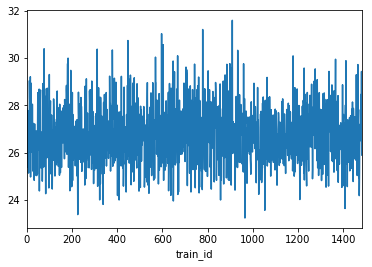

In [69]:
df_raw_train.groupby(np.floor(df_raw_train['train_id']/1000))['price'].mean().plot()
plt.show()

In [76]:
print df_raw_train[df_raw_train['name']=='Bundle']['item_description']

122        Sizes and info of clothes can be found on thei...
290                               [rm] Discounted price [rm]
932        1pc Oversize Turtle Neck Plaid Poncho Cape 1pc...
1053       Minor play scratches Played with condition Tha...
2158                          Please check to see if its all
4729                                Bundle reserved for Evat
4806       White and orange are both Baby Gap, blue strip...
6580                                Bundle Free Shipping JEM
6841       Just cleaning out my closet come with 2 tshirt...
8025       (8) XXL 14x17 Shipping Polymailers (8) 10x13 P...
8977                                         For andres andy
9006       *this is an individual listing for 2 phone sta...
9112       Triumph bra-free No flaws Used twice Sports br...
11306      Swimsuit one piece bodysuit Bodysuit Dress-fre...
11860                                     Here is the bundle
12380      Bundle 3 brand new Milani eyeshadow palettes -...
12802                   